<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B5%5D_System_of_ODEs_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Credits : Mahmoud Asem @Asem000  October 2021

In [2]:
#Imports
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax
!pip install numba
import numba

### System of ODEs numerical solution
$\large \frac{dx}{dt}  = x$ <br> 

$\large \frac{dy}{dt} = x - y$ <br>

$x(t=0) = 1$

$y(t=0) = 2$

<br>
$\text{analytical solution}$

$x(t) = e^{t}$

$y(t) = \frac{1}{2} e^{t} + \frac{3}{2} e^{-t}$

In [3]:
'''

solve 
dx/dt = x
dy/dt = x-y

x(0) = 1
y(0) = 2

solution =

x(t) = exp(t)
y(t) = 0.5*exp(t) +1.5*exp(-t)

'''

@numba.njit
def RK4(odefun,ics,h,span,degree):
    
    N= int( (span[1]-span[0])/h )
    
    tY = np.zeros((N+1,degree+1))
    tY[0,1:] = ics
    
    
    for  i in range(N):
        tY[i+1,0] = tY[i,0] + h

        k1= odefun(tY[i,0]       , tY[i,1:])
        k2= odefun(tY[i,0] +(h/2), tY[i,1:] +(h*k1)/2 )
        k3= odefun(tY[i,0] +(h/2), tY[i,1:] +(h*k2)/2)
        k4= odefun(tY[i,0] +(h)  , tY[i,1:] +(h*k3))
        
        tY[i+1,1:] = tY[i,1:] + h*(1/6) * (k1+2*k2+2*k3+k4)
        
    return tY[:,0],tY[:,1:]

@numba.njit
def system_of_ode(t,V):
  y1,y2 = V[0],V[1]
  return np.array([y1,y1-y2])

t,y=RK4(system_of_ode,
        ics=np.array([1,2]),
        h=1e-3,
        span=np.array([1e-4,np.pi]),
        degree =2)

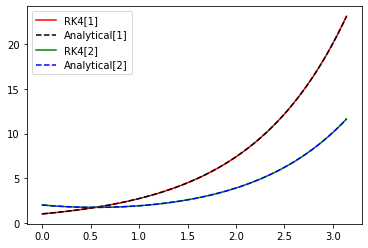

In [4]:
plt.plot(t,y[:,0],'-r',label='RK4[1]')
plt.plot(t,np.exp(t),'--k',label='Analytical[1]')

plt.plot(t,y[:,1],'-g',label='RK4[2]')
plt.plot(t,0.5*np.exp(t)+1.5*np.exp(-t),'--b',label='Analytical[2]')

plt.legend()

### Constructing the MLP

In [5]:
N_b = 1_000
N_c = 10_000

tmin,tmax=0. ,jnp.pi

'''boundary conditions'''


# y1[0] = 1
y1_t0 = jnp.zeros([N_b,1],dtype='float32')
y1_ic = jnp.ones_like(y1_t0) 
Y1_IC = jnp.concatenate([y1_t0,y1_ic],axis=1)

# y2[0] = 2
y2_t0 = jnp.zeros([N_b,1],dtype='float32')
y2_ic = jnp.ones_like(y2_t0) * 2
Y2_IC = jnp.concatenate([y2_t0,y2_ic],axis=1)

conds = [Y1_IC,Y2_IC]

#collocation points

key=jax.random.PRNGKey(0)

t_c = jax.random.uniform(key,minval=tmin,maxval=tmax,shape=(N_c,1))
colloc = t_c

def ODE_loss(t,y1,y2):

  y1_t=lambda t:jax.grad(lambda t:jnp.sum(y1(t)))(t)
  y2_t=lambda t:jax.grad(lambda t:jnp.sum(y2(t)))(t)

  return y1_t(t) - y1(t)  , y2_t(t) - y1(t) + y2(t)


In [6]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)

def loss_fun(params,colloc,conds):
  t_c =colloc[:,[0]]

  y1_func = lambda t : fwd(params,t)[:,[0]]
  y1_func_t=lambda t:jax.grad(lambda t:jnp.sum(y1_func(t)))(t)

  y2_func = lambda t : fwd(params,t)[:,[1]]
  y2_func_t=lambda t:jax.grad(lambda t:jnp.sum(y2_func(t)))(t)

  loss_y1,loss_y2  =ODE_loss(t_c,y1_func,y2_func)

  loss = jnp.mean( loss_y1 **2) 
  loss+= jnp.mean(loss_y2 **2)

  t_ic,y1_ic = conds[0][:,[0]],conds[0][:,[1]]  
  loss += MSE(y1_ic,y1_func(t_ic))

  t_ic,y2_ic = conds[1][:,[0]],conds[1][:,[1]]  
  loss += MSE(y2_ic,y2_func(t_ic))

  return  loss

@jax.jit
def update(opt_state,params,colloc,conds):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)
  
  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  #Update params
  # return jax.tree_multimap(lambda params,grads : params-LR*grads, params,grads)
  return opt_state,params


In [7]:
# construct the MLP of  6 hidden layers of 8 neurons for each layer
params = init_params([1] + [8]*2+[2])

In [8]:
optimizer = optax.adam(1e-2)
opt_state = optimizer.init(params)

In [9]:
fwd(params,t_c)[:,[0]].shape

(10000, 1)

In [10]:
%%time
epochs = 10_000
for _ in range(epochs):
  opt_state,params = update(opt_state,params,colloc,conds)

  # print loss and epoch info
  if _ %(100) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=4.391e+00
Epoch=100	loss=3.921e-01
Epoch=200	loss=3.891e-01
Epoch=300	loss=3.876e-01
Epoch=400	loss=3.866e-01
Epoch=500	loss=3.855e-01
Epoch=600	loss=3.840e-01
Epoch=700	loss=3.820e-01
Epoch=800	loss=3.788e-01
Epoch=900	loss=3.726e-01
Epoch=1000	loss=3.555e-01
Epoch=1100	loss=3.070e-01
Epoch=1200	loss=2.254e-01
Epoch=1300	loss=1.834e-01
Epoch=1400	loss=1.354e-01
Epoch=1500	loss=1.085e-01
Epoch=1600	loss=8.198e-02
Epoch=1700	loss=6.454e-02
Epoch=1800	loss=5.201e-02
Epoch=1900	loss=4.232e-02
Epoch=2000	loss=3.476e-02
Epoch=2100	loss=2.897e-02
Epoch=2200	loss=2.339e-02
Epoch=2300	loss=1.980e-02
Epoch=2400	loss=1.632e-02
Epoch=2500	loss=1.425e-02
Epoch=2600	loss=1.194e-02
Epoch=2700	loss=1.174e-02
Epoch=2800	loss=9.231e-03
Epoch=2900	loss=7.939e-03
Epoch=3000	loss=7.260e-03
Epoch=3100	loss=6.298e-03
Epoch=3200	loss=7.007e-02
Epoch=3300	loss=5.132e-03
Epoch=3400	loss=4.541e-03
Epoch=3500	loss=5.706e-03
Epoch=3600	loss=3.834e-03
Epoch=3700	loss=3.433e-03
Epoch=3800	loss=3.316e-0

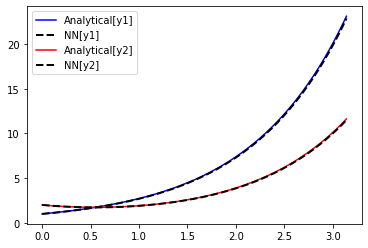

In [11]:
dT = 1e-3
Tf = jnp.pi
T = np.arange(0,Tf+dT,dT)

plt.plot(t,np.exp(t),'-b',label='Analytical[y1]')
plt.plot(T,fwd(params,T.reshape(-1,1))[:,0],'--k',label='NN[y1]',linewidth=2)

plt.plot(t,0.5*np.exp(t)+1.5*np.exp(-t),'-r',label='Analytical[y2]')
plt.plot(T,fwd(params,T.reshape(-1,1))[:,1],'--k',label='NN[y2]',linewidth=2)

plt.legend()